# Analysis of Classified Government Repositories

## Automatic data analysis 

This notebook analyzes the `classified_gov_repositories.csv` file generated by the IAI project. 
The analysis includes:
1. Loading and initial exploration of the data.
2. Frequency analysis of key categorical features (topics, languages, accounts).
3. Text-based clustering of repository summaries to identify thematic groups.

## 1. Setup and Load Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re

# Download stopwords if not already present (run once)
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

stop_words = list(stopwords.words('english'))

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

[nltk_data] Downloading package stopwords to /home/theo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Define the path to the data file
# Assuming the notebook is in 'notebooks/' and data is in 'data/' relative to project root
data_file_path = "../data/20250527_135217_1cf94898/classified_gov_repositories.csv"

try:
    df = pd.read_csv(data_file_path)
    print(f"Successfully loaded data from {data_file_path}")
except FileNotFoundError:
    print(f"Error: File not found at {data_file_path}. Please check the path.")
    df = pd.DataFrame() # Create an empty DataFrame to avoid further errors

if not df.empty:
    print(f"\nDataset shape: {df.shape}")

Successfully loaded data from ../data/20250527_135217_1cf94898/classified_gov_repositories.csv

Dataset shape: (150, 10)


## 2. Initial Data Exploration

In [8]:
if not df.empty:
    print("First 5 rows of the dataset:")
    display(df.head())
    
    print("\nDataset info:")
    df.info()
    
    print("\nSummary statistics for numerical columns:")
    display(df.describe())
    
    print("\nMissing values per column:")
    display(df.isnull().sum())

First 5 rows of the dataset:


,name,description,stars,forks,language,url,readme,account,topic,summary
0,accessible-autocomplete,"An autocomplete component, built to be accessi...",942,149,JavaScript,https://github.com/alphagov/accessible-autocom...,# Accessible autocomplete\n\nThe accessible au...,alphagov,accessibility-tools,The repository provides an accessible autocomp...
1,hamagen-react-native,Israel's Ministry of Health's COVID-19 Exposur...,510,153,TypeScript,https://github.com/MohGovIL/hamagen-react-native,# Hamagen\n![Build](https://github.com/MohGovI...,MohGovIL,public-health-tech,Hamagen is a COVID-19 exposure prevention app ...
2,falcon,Falcon: The Hyperledger Fabric Deployment Help...,403,42,Smarty,https://github.com/npci/falcon,## Falcon: Hyperledger Fabric Deployment Helpe...,npci,blockchain-deployment,Falcon is an open-source tool designed to simp...
3,pdf2md,A PDF to Markdown converter,315,57,JavaScript,https://github.com/opengovsg/pdf2md,# pdf2md\n\nJavaScript npm library to parse PD...,opengovsg,pdf-to-markdown,**pdf2md** is a JavaScript npm library designe...
4,FormSG,Form builder for the Singapore Government,298,95,TypeScript,https://github.com/opengovsg/FormSG,"<p align=""left"">\n <a href=""https://form.gov....",opengovsg,government-tech,This repository provides a form builder platfo...



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         150 non-null    object
 1   description  150 non-null    object
 2   stars        150 non-null    int64 
 3   forks        150 non-null    int64 
 4   language     150 non-null    object
 5   url          150 non-null    object
 6   readme       150 non-null    object
 7   account      150 non-null    object
 8   topic        150 non-null    object
 9   summary      150 non-null    object
dtypes: int64(2), object(8)
memory usage: 11.8+ KB

Summary statistics for numerical columns:


,stars,forks
count,150.000000,150.000000
mean,51.920000,19.560000
std,100.168953,49.901309
min,10.000000,0.000000
25%,15.000000,5.000000
50%,20.500000,8.000000
75%,43.500000,17.750000
max,942.000000,559.000000



Missing values per column:


name           0
description    0
stars          0
forks          0
language       0
url            0
readme         0
account        0
topic          0
summary        0
dtype: int64

Handle missing values if necessary. For text columns used in clustering, fill NaNs with empty strings.

In [9]:
if not df.empty:
    # Fill NaN in 'description', 'readme', 'summary', 'topic' for robust processing
    for col in ['description', 'readme', 'summary', 'topic']:
        if col in df.columns:
            df[col] = df[col].fillna('')
    
    # 'language' can be filled with 'Unknown' or similar
    if 'language' in df.columns:
        df['language'] = df['language'].fillna('Unknown')
        
    print("\nMissing values after handling:")
    display(df.isnull().sum())


Missing values after handling:


name           0
description    0
stars          0
forks          0
language       0
url            0
readme         0
account        0
topic          0
summary        0
dtype: int64

## 3. Frequency Analysis

### 3.1. Frequency of Repository Topics

/tmp/ipykernel_222019/3326619396.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.values, y=topic_counts.index, palette='viridis')


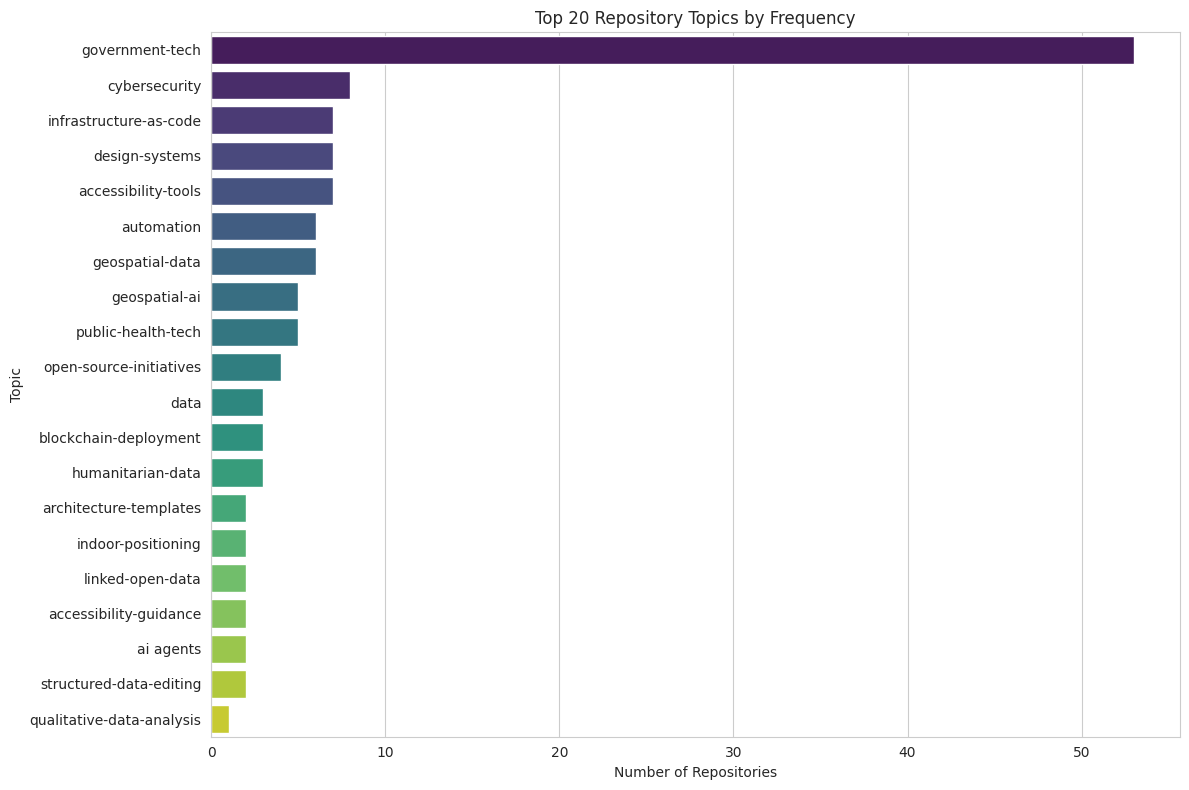


Topic Counts (Top 20):


topic
government-tech              53
cybersecurity                 8
infrastructure-as-code        7
design-systems                7
accessibility-tools           7
automation                    6
geospatial-data               6
geospatial-ai                 5
public-health-tech            5
open-source-initiatives       4
data                          3
blockchain-deployment         3
humanitarian-data             3
architecture-templates        2
indoor-positioning            2
linked-open-data              2
accessibility-guidance        2
ai agents                     2
structured-data-editing       2
qualitative-data-analysis     1
Name: count, dtype: int64

In [10]:
if not df.empty and 'topic' in df.columns:
    plt.figure(figsize=(12, 8))
    topic_counts = df['topic'].value_counts().nlargest(20) # Show top 20 topics
    sns.barplot(x=topic_counts.values, y=topic_counts.index, palette='viridis')
    plt.title('Top 20 Repository Topics by Frequency')
    plt.xlabel('Number of Repositories')
    plt.ylabel('Topic')
    plt.tight_layout()
    plt.show()
    
    print("\nTopic Counts (Top 20):")
    display(topic_counts)
else:
    print("DataFrame is empty or 'topic' column is missing.")

### 3.2. Frequency of Programming Languages

/tmp/ipykernel_222019/1881635305.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_counts.values, y=language_counts.index, palette='mako')


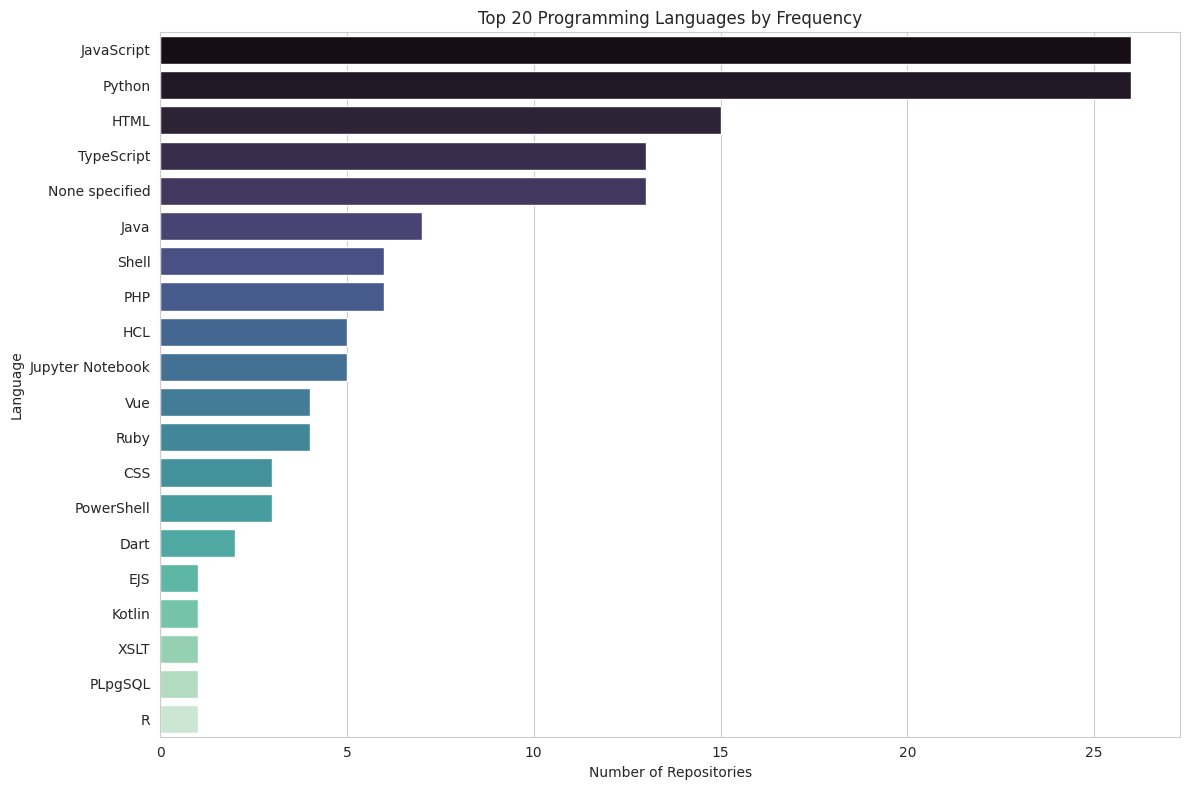


Language Counts (Top 20):


language
JavaScript          26
Python              26
HTML                15
TypeScript          13
None specified      13
Java                 7
Shell                6
PHP                  6
HCL                  5
Jupyter Notebook     5
Vue                  4
Ruby                 4
CSS                  3
PowerShell           3
Dart                 2
EJS                  1
Kotlin               1
XSLT                 1
PLpgSQL              1
R                    1
Name: count, dtype: int64

In [11]:
if not df.empty and 'language' in df.columns:
    plt.figure(figsize=(12, 8))
    language_counts = df['language'].value_counts().nlargest(20) # Show top 20 languages
    sns.barplot(x=language_counts.values, y=language_counts.index, palette='mako')
    plt.title('Top 20 Programming Languages by Frequency')
    plt.xlabel('Number of Repositories')
    plt.ylabel('Language')
    plt.tight_layout()
    plt.show()
    
    print("\nLanguage Counts (Top 20):")
    display(language_counts)
else:
    print("DataFrame is empty or 'language' column is missing.")

### 3.3. Frequency of Government Accounts

/tmp/ipykernel_222019/3365368763.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=account_counts.values, y=account_counts.index, palette='rocket')


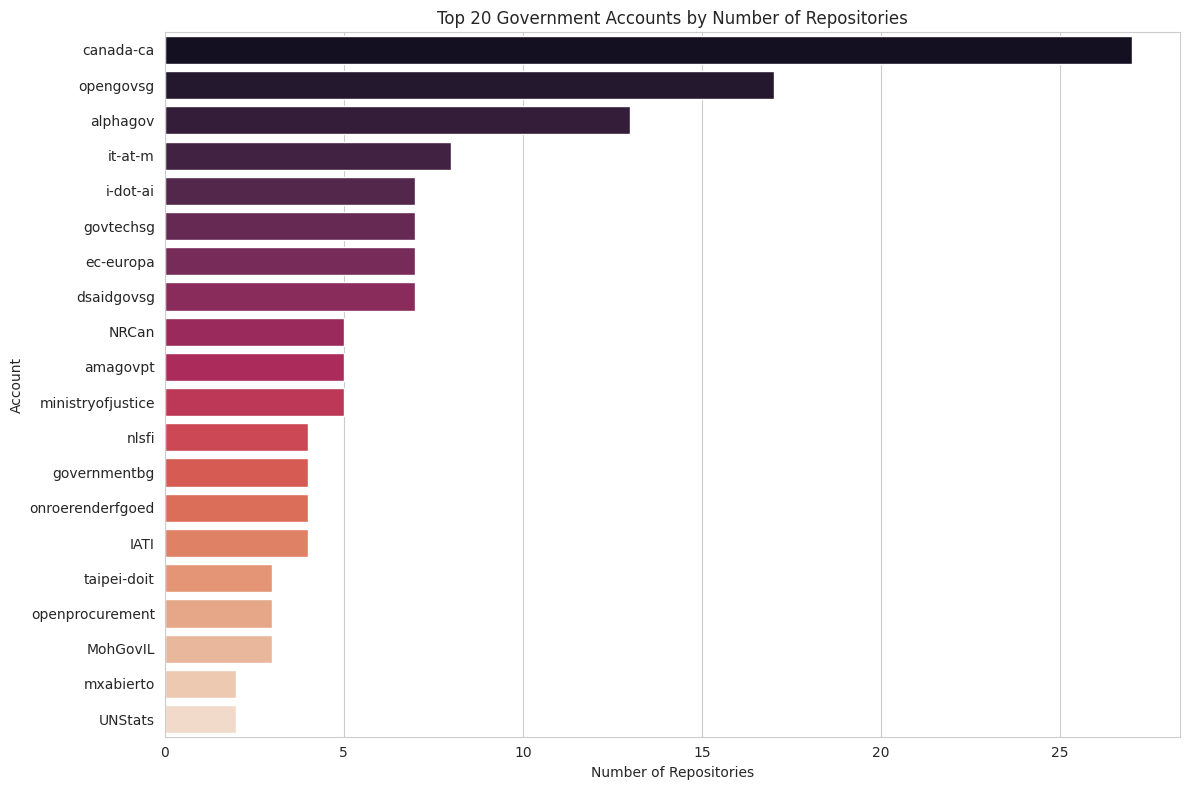


Account Counts (Top 20):


account
canada-ca            27
opengovsg            17
alphagov             13
it-at-m               8
i-dot-ai              7
govtechsg             7
ec-europa             7
dsaidgovsg            7
NRCan                 5
amagovpt              5
ministryofjustice     5
nlsfi                 4
governmentbg          4
onroerenderfgoed      4
IATI                  4
taipei-doit           3
openprocurement       3
MohGovIL              3
mxabierto             2
UNStats               2
Name: count, dtype: int64

In [12]:
if not df.empty and 'account' in df.columns:
    plt.figure(figsize=(12, 8))
    account_counts = df['account'].value_counts().nlargest(20) # Show top 20 accounts
    sns.barplot(x=account_counts.values, y=account_counts.index, palette='rocket')
    plt.title('Top 20 Government Accounts by Number of Repositories')
    plt.xlabel('Number of Repositories')
    plt.ylabel('Account')
    plt.tight_layout()
    plt.show()
    
    print("\nAccount Counts (Top 20):")
    display(account_counts)
else:
    print("DataFrame is empty or 'account' column is missing.")

## 4. Text Clustering of Repository Summaries

We will use the 'summary' column for clustering. First, we need to preprocess the text and vectorize it using TF-IDF.

In [13]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\W', ' ', text) # Remove special characters
    text = re.sub(r'\s+', ' ', text) # Remove multiple spaces
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2] # Remove stopwords and short words
    return " ".join(words)

if not df.empty and 'summary' in df.columns:
    # Ensure 'summary' column exists and is not empty
    if df['summary'].isnull().all() or (df['summary'] == '').all():
        print("Warning: 'summary' column is empty or all NaN. Clustering cannot proceed.")
        summaries_for_clustering = pd.Series([])
    else:
        df['processed_summary'] = df['summary'].apply(preprocess_text)
        summaries_for_clustering = df['processed_summary'][df['processed_summary'].str.strip() != '']
        
        if summaries_for_clustering.empty:
            print("Warning: No valid summaries available after preprocessing. Clustering cannot proceed.")
        else:
            print(f"{len(summaries_for_clustering)} summaries available for clustering after preprocessing.")
            display(summaries_for_clustering.head())
else:
    print("DataFrame is empty or 'summary' column is missing.")
    summaries_for_clustering = pd.Series([]) # Define to avoid errors later

150 summaries available for clustering after preprocessing.


0    repository provides accessible autocomplete co...
1    hamagen covid exposure prevention app develope...
2    falcon open source tool designed simplify depl...
3    pdf2md javascript npm library designed parse p...
4    repository provides form builder platform desi...
Name: processed_summary, dtype: object

In [14]:
if not summaries_for_clustering.empty:
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.95,  # ignore terms that appear in more than 95% of documents
        min_df=2,     # ignore terms that appear in less than 2 documents
        max_features=1000 # consider only top 1000 features
    )
    tfidf_matrix = tfidf_vectorizer.fit_transform(summaries_for_clustering)
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
else:
    print("Skipping TF-IDF vectorization as no valid summaries are available.")
    tfidf_matrix = None

TF-IDF matrix shape: (150, 566)


### 4.1. Determine Optimal Number of Clusters (Elbow Method)

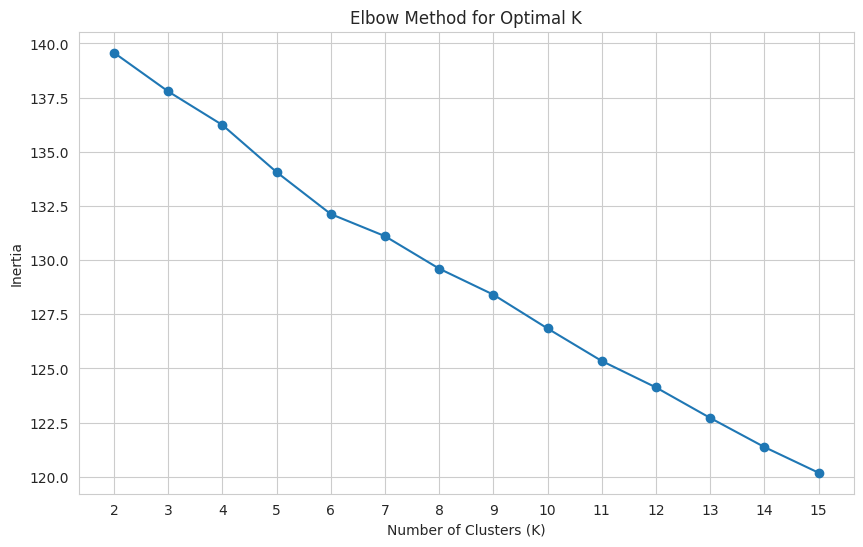

Suggested optimal K based on elbow heuristic: 6


In [15]:
if tfidf_matrix is not None and tfidf_matrix.shape[0] > 1: # Need at least 2 samples for clustering
    inertia = []
    # Consider a range of K. If dataset is small, K_range might need adjustment.
    max_k = min(15, tfidf_matrix.shape[0]) # Max K is 15 or num_samples
    if max_k <= 1:
        print("Not enough samples to perform K-Means clustering for a range of K.")
    else:
        k_range = range(2, max_k + 1)
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            kmeans.fit(tfidf_matrix)
            inertia.append(kmeans.inertia_)
        
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertia, marker='o')
        plt.title('Elbow Method for Optimal K')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Inertia')
        plt.xticks(k_range)
        plt.show()
        
        # Suggest an optimal K based on the elbow (heuristic)
        # This is a simple heuristic, visual inspection is often better.
        if len(inertia) > 1:
            # Calculate differences between consecutive inertia values
            diffs = np.diff(inertia)
            # Calculate differences of these differences (second derivative)
            diffs2 = np.diff(diffs)
            # The elbow is where the second derivative is maximized (most change in slope)
            # Add 2 to k_range index because k_range starts at 2 and diffs2 index is 0-based for k_range[2]
            if len(diffs2) > 0:
                optimal_k_elbow = k_range[np.argmax(diffs2) + 1] if len(diffs2) > 0 else k_range[0]
                print(f"Suggested optimal K based on elbow heuristic: {optimal_k_elbow}")
            else:
                optimal_k_elbow = k_range[0] # Default to smallest K if not enough points for 2nd derivative
                print(f"Could not determine optimal K via heuristic, defaulting to K={optimal_k_elbow}. Please inspect the plot.")
        else:
            optimal_k_elbow = 2 # Default if only one point in inertia
            print(f"Not enough data points for elbow heuristic, defaulting to K={optimal_k_elbow}. Please inspect the plot.")
else:
    print("Skipping Elbow method as TF-IDF matrix is not available or has too few samples.")
    optimal_k_elbow = 0 # Indicates clustering cannot proceed

### 4.2. Apply K-Means Clustering

In [16]:
# Choose a K based on the elbow plot or a fixed number if the plot is unclear
# For this example, let's use the suggested optimal_k_elbow if valid, or a default like 5.
CHOSEN_K = 0
if 'optimal_k_elbow' in locals() and optimal_k_elbow > 1:
    CHOSEN_K = optimal_k_elbow
elif tfidf_matrix is not None and tfidf_matrix.shape[0] >= 5: # Ensure enough samples for K=5
    CHOSEN_K = 5
    print(f"Elbow method did not yield a clear K or was skipped. Using default K={CHOSEN_K}.")
else:
    print("Not enough samples for clustering or TF-IDF matrix not available. Skipping K-Means.")

cluster_labels = None
if CHOSEN_K > 1 and tfidf_matrix is not None and tfidf_matrix.shape[0] >= CHOSEN_K:
    kmeans = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    
    # Add cluster labels back to the DataFrame (for the subset that had valid summaries)
    # Ensure indices align if summaries_for_clustering was a subset of df
    df_clustered = df.loc[summaries_for_clustering.index].copy() # Work on a copy
    df_clustered['text_cluster'] = cluster_labels
    
    print(f"\nRepositories assigned to {CHOSEN_K} clusters.")
    print("Cluster distribution:")
    display(df_clustered['text_cluster'].value_counts().sort_index())
    
    # Merge cluster labels back into the original df, if desired
    df['text_cluster'] = pd.NA # Initialize with NA
    if 'df_clustered' in locals():
        df.loc[df_clustered.index, 'text_cluster'] = df_clustered['text_cluster']
else:
    print(f"Skipping K-Means clustering. CHOSEN_K={CHOSEN_K}, tfidf_matrix available: {tfidf_matrix is not None}")


Repositories assigned to 6 clusters.
Cluster distribution:


text_cluster
0    23
1    33
2    19
3    28
4    20
5    27
Name: count, dtype: int64

### 4.3. Analyze Clusters - Top Terms

In [17]:
if 'kmeans' in locals() and kmeans is not None and 'tfidf_vectorizer' in locals() and tfidf_vectorizer is not None and CHOSEN_K > 1:
    print(f"Top terms per cluster (K={CHOSEN_K}):")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    for i in range(CHOSEN_K):
        print(f"Cluster {i}:", end='')
        for ind in order_centroids[i, :10]: # Top 10 terms
            print(f' {terms[ind]}', end=',')
        print("\n")
else:
    print("Skipping top terms analysis as clustering was not performed or models are not available.")

Top terms per cluster (K=6):
Cluster 0: security, government, cloud, ensure, systems, guardrails, repository, provides, accessibility, standards,

Cluster 1: repository, tool, designed, setup, testing, streamline, integration, includes, using, development,

Cluster 2: open, government, source, canada, repository, public, collaboration, innovation, serves, practices,

Cluster 3: digital, repository, documentation, project, readme, resources, github, provides, includes, services,

Cluster 4: data, transparency, repository, related, iati, aid, open, portal, ministry, international,

Cluster 5: python, library, designed, based, models, learning, language, applications, processing, provides,



### 4.4. Visualize Clusters (PCA)

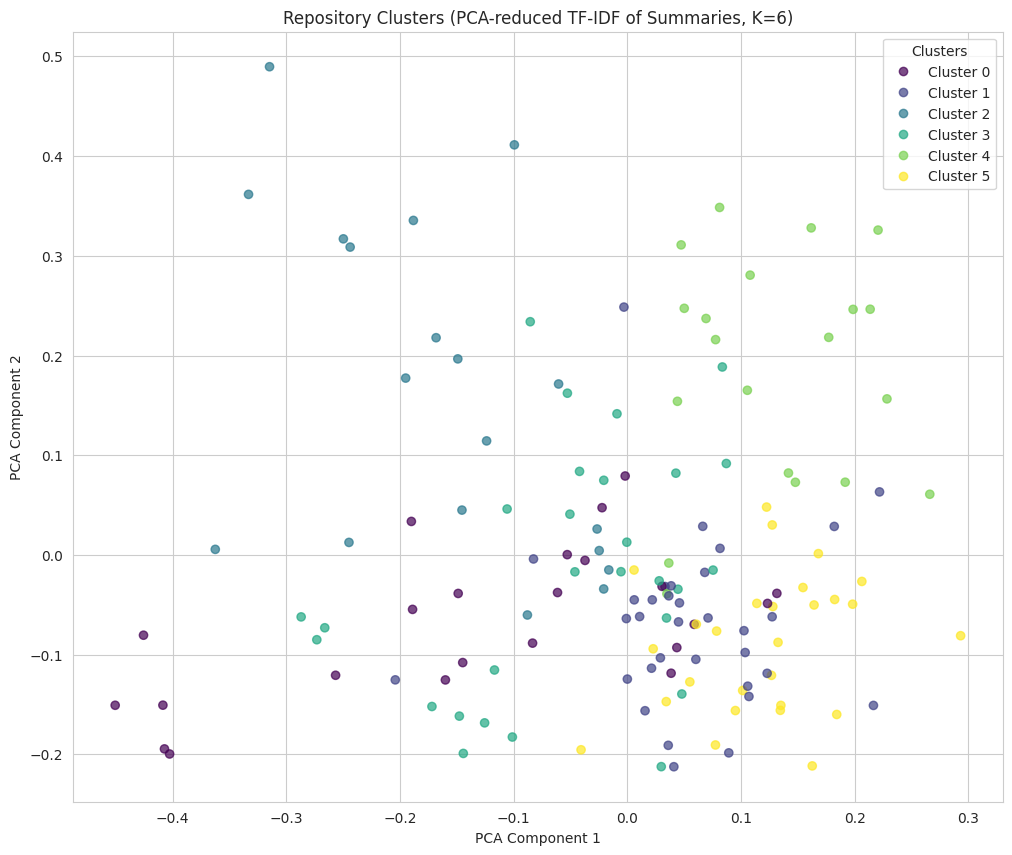

In [18]:
if cluster_labels is not None and tfidf_matrix is not None and tfidf_matrix.shape[0] > 1 and tfidf_matrix.shape[1] > 1:
    # Reduce dimensionality using PCA
    # Ensure n_components is less than min(n_samples, n_features)
    n_components_pca = min(2, tfidf_matrix.shape[0], tfidf_matrix.shape[1])
    if n_components_pca < 2:
        print("Cannot perform PCA with less than 2 components. Skipping visualization.")
    else:
        pca = PCA(n_components=n_components_pca, random_state=42)
        # K-means works with sparse matrices, but PCA in scikit-learn typically expects dense arrays.
        # If tfidf_matrix is very large, .toarray() can cause memory issues.
        # Consider TruncatedSVD for sparse data if memory is a concern.
        try:
            reduced_features = pca.fit_transform(tfidf_matrix.toarray())
            
            plt.figure(figsize=(12, 10))
            scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
            plt.title(f'Repository Clusters (PCA-reduced TF-IDF of Summaries, K={CHOSEN_K})')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            
            # Create a legend
            if CHOSEN_K <= 10: # Only show legend if K is not too large
                legend_elements = scatter.legend_elements()
                plt.legend(handles=legend_elements[0], labels=[f'Cluster {i}' for i in range(CHOSEN_K)], title="Clusters")
            plt.show()
        except MemoryError:
            print("MemoryError: TF-IDF matrix is too large to convert to dense array for PCA. Consider using TruncatedSVD or sampling.")
        except Exception as e:
            print(f"An error occurred during PCA or plotting: {e}")
else:
    print("Skipping cluster visualization as cluster labels or TF-IDF matrix are not available or insufficient data.")

### 4.5. Explore Clusters with Original Topics

In [19]:
if 'df_clustered' in locals() and 'text_cluster' in df_clustered.columns and 'topic' in df_clustered.columns:
    print("\nDistribution of original 'topic' labels within each new text_cluster:")
    for i in range(CHOSEN_K):
        print(f"\n--- Cluster {i} --- Top Original Topics ---")
        cluster_data = df_clustered[df_clustered['text_cluster'] == i]
        if not cluster_data.empty:
            topic_distribution = cluster_data['topic'].value_counts().nlargest(5)
            if not topic_distribution.empty:
                display(topic_distribution)
            else:
                print("No topics found or topic column was empty for this cluster.")
            
            # Show a few example summaries from this cluster
            print("\nExample summaries from this cluster:")
            # Ensure 'summary' column exists in df_clustered
            if 'summary' in cluster_data.columns:
                display(cluster_data[['name', 'summary']].head(3))
            else:
                display(cluster_data[['name']].head(3)) # Fallback if summary is not there
        else:
            print("No data in this cluster.")
else:
    print("Skipping analysis of original topics within text clusters as clustering data is not fully available.")


Distribution of original 'topic' labels within each new text_cluster:

--- Cluster 0 --- Top Original Topics ---


topic
government-tech           9
cybersecurity             7
geospatial-ai             1
infrastructure-as-code    1
design-systems            1
Name: count, dtype: int64


Example summaries from this cluster:


,name,summary
4,FormSG,This repository provides a form builder platfo...
15,openprocurement.api,The repository provides an API interface for i...
16,awesome-gov-datasets,"The repository, **Awesome UK Government Datase..."



--- Cluster 1 --- Top Original Topics ---


topic
government-tech           8
automation                5
infrastructure-as-code    4
accessibility-tools       3
design-systems            2
Name: count, dtype: int64


Example summaries from this cluster:


,name,summary
0,accessible-autocomplete,The repository provides an accessible autocomp...
2,falcon,Falcon is an open-source tool designed to simp...
3,pdf2md,**pdf2md** is a JavaScript npm library designe...



--- Cluster 2 --- Top Original Topics ---


topic
government-tech            15
open-source-initiatives     1
data science                1
architecture-templates      1
accessibility-guidance      1
Name: count, dtype: int64


Example summaries from this cluster:


,name,summary
7,Open_First_Whitepaper,"The ""Open First Whitepaper"" is a draft documen..."
13,redbox,This GitHub repository focuses on integrating ...
14,GoGovSG,GoGovSG is the official link shortener service...



--- Cluster 3 --- Top Original Topics ---


topic
government-tech              13
accessibility-tools           3
design-systems                2
blockchain-deployment         2
ethiopian-app-development     1
Name: count, dtype: int64


Example summaries from this cluster:


,name,summary
5,autenticacao.gov,This GitHub repository provides the official m...
20,accessibility-tool-audit,This GitHub repository focuses on auditing aut...
22,PCTF-CCP,The GitHub repository contains the Public Sect...



--- Cluster 4 --- Top Original Topics ---


topic
government-tech      6
humanitarian-data    3
data                 2
linked-open-data     2
geospatial-data      2
Name: count, dtype: int64


Example summaries from this cluster:


,name,summary
1,hamagen-react-native,Hamagen is a COVID-19 exposure prevention app ...
9,Taipei-City-Dashboard,The Taipei City Dashboard is an open-source pr...
19,multimodal-learning-hands-on-tutorial,This repository explores the use of Transforme...



--- Cluster 5 --- Top Original Topics ---


topic
geospatial-ai         3
indoor-positioning    2
geospatial-data       2
government-tech       2
design-systems        2
Name: count, dtype: int64


Example summaries from this cluster:


,name,summary
8,geo-deep-learning,The **Geo-Deep-Learning** repository focuses o...
11,europa-component-library,ECL (Europa Component Library) is a design sys...
28,rn-contact-tracing,RN-Contact-Tracing is a React Native library d...


## 5. Further Analysis Ideas

- **Correlation Analysis**: Explore correlations between numerical features (stars, forks) and categorical features (e.g., average stars per topic/language).
- **Time Series Analysis**: If repository creation/update dates were available, analyze trends over time.
- **Network Analysis**: If user/organization collaboration data were available, build and analyze a collaboration network.
- **Sentiment Analysis**: Perform sentiment analysis on READMEs or descriptions.
- **Advanced Clustering**: Use more sophisticated clustering algorithms like DBSCAN or hierarchical clustering.
- **Topic Modeling (LDA)**: Apply Latent Dirichlet Allocation on READMEs/descriptions to discover underlying topics in a more unsupervised way than the pre-assigned 'topic' column.

## 6. Conclusion

In [20]:
if not df.empty:
    print("Analysis complete. Key insights:")
    if 'topic_counts' in locals():
        print(f"- Most frequent repository topic: {topic_counts.index[0] if not topic_counts.empty else 'N/A'} ({topic_counts.iloc[0] if not topic_counts.empty else 0} repositories)")
    if 'language_counts' in locals():
        print(f"- Most frequent programming language: {language_counts.index[0] if not language_counts.empty else 'N/A'} ({language_counts.iloc[0] if not language_counts.empty else 0} repositories)")
    if cluster_labels is not None and CHOSEN_K > 1:
        print(f"- Repositories were grouped into {CHOSEN_K} clusters based on their summaries.")
        print("- Review the 'Top terms per cluster' and 'PCA visualization' sections for details on these clusters.")
    print("\nThis notebook provides a starting point for analyzing the classified government repositories.")
    print("Further investigation into specific clusters or topics can yield more detailed insights.")
else:
    print("Analysis could not be completed as the DataFrame is empty. Please check the data loading step.")

Analysis complete. Key insights:
- Most frequent repository topic: government-tech (53 repositories)
- Most frequent programming language: JavaScript (26 repositories)
- Repositories were grouped into 6 clusters based on their summaries.
- Review the 'Top terms per cluster' and 'PCA visualization' sections for details on these clusters.

This notebook provides a starting point for analyzing the classified government repositories.
Further investigation into specific clusters or topics can yield more detailed insights.
